### 1. Vanilla GAN

#### 💡 라이브러리 불러오기

- `make_grid` : 격자 형태의 이미지를 만들게 한다. 
- `imageio` : gif 파일을 만들기 위해 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
from matplotlib import pyplot as plt

#### 💡 패션 아이템 불러오기

- 티셔츠, 바지, 풀오버, 드레스, 코드, 샌들, 셔츠, 스니커즈, 가방, 앵클부츠로 구성된 FashionMNIST 데이터를 불러온다.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])
trainset = FashionMNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/home/user/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### 💡 생성자 구축하기

- `self.n_features`, `self.n_out`
    - 생성자는 잠재변수로부터 784(28x28) 크기인 벡터를 생성한다.
    - 따라서 잠재 변수의 크기를 임의로 정하고 출력 크기는 이미지를 일렬로 편 크기인 784로 정의
- `self.linear`
    - 기본 GAN은 nn.Linear를 사용하여 모델 구축
    - 활성 함수로는 ReakyReLU (음수 구간의 양의 기울기를 주어 값을 계산 y=0.2x)
- `x`
    - 정의된 MLP를 거치고 784 크기의 벡터를 크기가 28x28인 흑백 이미지로 변경하여 새로운 이미지 생성

In [84]:
class Generator(nn.Module) :
    def __init__(self) :
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.linear = nn.Sequential(nn.Linear(self.n_features, 256),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(256, 512),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(512, 1024),
                                    nn.LeakyReLU(0.2),
                                    # self.n_out 중요중요
                                    nn.Linear(1024, self.n_out),
                                    nn.Tanh())
        
    def forward(self, x) :
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)
        return x

#### 💡 구별자 구축하기

In [12]:
class Discriminator(nn.Module) :
    def __init__(self) :
        super(Discriminator, self).__init__()
        # 이미지를 일렬로 편 크기 784
        self.n_in = 784
        
        # 진위여부를 판단하기 위해 하나의 숫자로 정의
        self.n_out = 1
        # 구조를 정의
        self.linear = nn.Sequential(nn.Linear(self.n_in, 1024),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3),
                                    nn.Linear(1024, 512),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 256),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3),
                                    nn.Linear(256, self.n_out),
                                    # 0과 1 사이의 값이 출력될 수 있도록
                                    nn.Sigmoid())
        
    def forward(self, x) :
        # 이미지를 벡터 형태로 변경하여 신경망에 넣는다. 
        x = x.view(-1, 784)
        x = self.linear(x)
        return x                

#### 💡 모델 정의하기

In [85]:
# 생성자와 구별자 각각 선언
generator = Generator().to(device)
discriminator = Discriminator().to(device)

#### 💡 손실함수 및 최적화 기법 정의하기

In [14]:
g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

# 학습 동안 손실 함수값과 샘플 이미지 저장을 위해 빈 리스트를 만든다.
g_losses = []
d_losses = []
images = []
criterion = nn.BCELoss()

#### 💡 잠재변수 및 라벨 정의하기

- `noise`
    - 기본적으로 크기가 128인 잠재 변수 n개를 무작위로 생성한다.
    - 손실함수에서 이미지의 진위 여부에 대한 계산을 하게 되므로, 실제 이미지의 클래스를 사용하지 않고 진짜 데이터는 라벨을 1로 생성자로부터 만들어진 이미지의 라벨을 0으로 정의하여 사용
- `label_ones`, `label_zeros`
    - 위를 위해 1과 0 라벨을 만들어주는 함수 정의

In [24]:
def noise(n, n_features=128) :
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size) :
    data = torch.ones(size, 1) 
    return data.to(device)

def label_zeros(size) :
    data = torch.zeros(size, 1)
    return data.to(device)

#### 💡 구별자 학습 함수 정의하기

In [90]:
# 진짜 이미지, 가짜 이미지, 최적화 함수를 받는다. 
def train_discriminator(optimizer, real_data, fake_data) :
    # 각 이미지의 진위 라벨을 할당하기 위해서 이미지의 개수 확인
    n = real_data.size(0)
    optimizer.zero_grad()
    
    # 진짜 이미지 판별
    prediction_real = discriminator(real_data)
    # 이미지 수만큼 1라벨을 넣어 손실 함수를 계산
    d_loss = criterion(prediction_real, label_ones(n))
    
    # 가짜 이미지 판별
    prediction_fake = discriminator(fake_data)
    # 이미지 수만큼 0라벨을 넣어 손실 함수를 계산
    g_loss = criterion(prediction_fake, label_zeros(n))
    
    loss = d_loss + g_loss
    loss.backward()
    optimizer.step()
    return loss.item()

#### 💡 생성자 학습 함수 정의하기

In [91]:
# 가짜 이미지, 최적화 함수를 받는다.
def train_generator(optimizer, fake_data) :
    # 이미지의 개수 저장
    n = fake_data.size(0)
    optimizer.zero_grad()
    # 가짜 이미지를 넣어 판별
    prediction = discriminator(fake_data)
    # 생성자 입장에서는 구별자가 가짜 이미지를 진짜 이미지라고 판단하도록 업데이트가 되어야 하므로
    # 0 라벨이 아니라 1라벨을 넣어 손실 함수 계산
    loss = criterion(prediction, label_ones(n))
    loss.backward()
    optimizer.step()
    return loss.item()

#### 💡 모델 학습하기

In [92]:
generator(noise(100)).shape

torch.Size([100, 1, 28, 28])

In [93]:
# 검증을 위한 무작위 잠재 변수 64개 생성 : torch.Size([64, 128])
test_noise = noise(64)

# 평균 손실값을 구하는데 사용하는 배치 수 저장 (600)
l = len(trainloader)

for epoch in range(151) :
    # 각 에폭마다 손실값을 초기화
    g_loss = 0.0
    d_loss = 0.0
    for data in trainloader :
        # 진짜 이미지를 받고 진짜 이미지의 개수를 정의 (100개)
        imgs, _ = data
        n = len(imgs)
        
        # 진짜 이미지의 개수만큼 가짜 이미지를 생성, detach()를 통해 불필요한 requires_grad 비활성화
        fake_data = generator(noise(n)).detach() 
        real_data = imgs.to(device)
        # 가지고 있는 이미지를 모두 구별자에 넣어 판별하고, 구별자를 업데이트하고 반환한 손실함수 값을 누적
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        
        
        # 생성자를 업데이트하고 반환한 손실 함수값을 누적
        fake_data = generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)
        
        
        
    # 검증을 위해 고정된 잠재 변수를 넣어 "이미지를 생성"
    # 변화를 알아보기 위해 격자 형태의 이미지로 만들어 "images 리스트에 저장"
    img = generator(test_noise).detach().cpu()
    img = make_grid(img)
    images.append(img)
    # 손실 함수값의 변화 저장
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)
    
    if epoch % 10 == 0:
        print("Epoch {}:g_loss:{:.3f} d_loss:{:.3f}\r" .format(epoch, g_loss/l, d_loss/l))

Epoch 0:g_loss:0.728 d_loss:1.401
Epoch 10:g_loss:0.728 d_loss:1.401
Epoch 20:g_loss:0.728 d_loss:1.401
Epoch 30:g_loss:0.728 d_loss:1.401
Epoch 40:g_loss:0.728 d_loss:1.401
Epoch 50:g_loss:0.728 d_loss:1.401
Epoch 60:g_loss:0.728 d_loss:1.401
Epoch 70:g_loss:0.728 d_loss:1.401
Epoch 80:g_loss:0.728 d_loss:1.401
Epoch 90:g_loss:0.728 d_loss:1.401
Epoch 100:g_loss:0.728 d_loss:1.401
Epoch 110:g_loss:0.728 d_loss:1.401
Epoch 120:g_loss:0.728 d_loss:1.401
Epoch 130:g_loss:0.728 d_loss:1.401
Epoch 140:g_loss:0.728 d_loss:1.401
Epoch 150:g_loss:0.728 d_loss:1.401


#### 💡 모델 저장하기

In [95]:
torch.save(discriminator.state_dict(), './model/fmnist_disc.pth')
torch.save(generator.state_dict(), './model/fmnist_gner.pth')

#### 💡 검증 이미지 변화를 gif 파일로 저장하기

- images 리스트의 원소 하나는 격자 형태로 만들어진 이미지들의 모임
    - 크기 : (3, 242, 242)인 하나의 텐서
    - 이미지 저장 형식을 맞추기 위해 ToPILImage()를 이용해 타입, 크기(242, 242, 3)으로 크기를 변환할 수 있다. 

In [99]:
to_image = transforms.ToPILImage()

# 이미지를 넘파이 배열로 변경하여 gif 파일로 만든다. 
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items.gif', imgs)

#### 💡 손실함수값 그래프 그리기

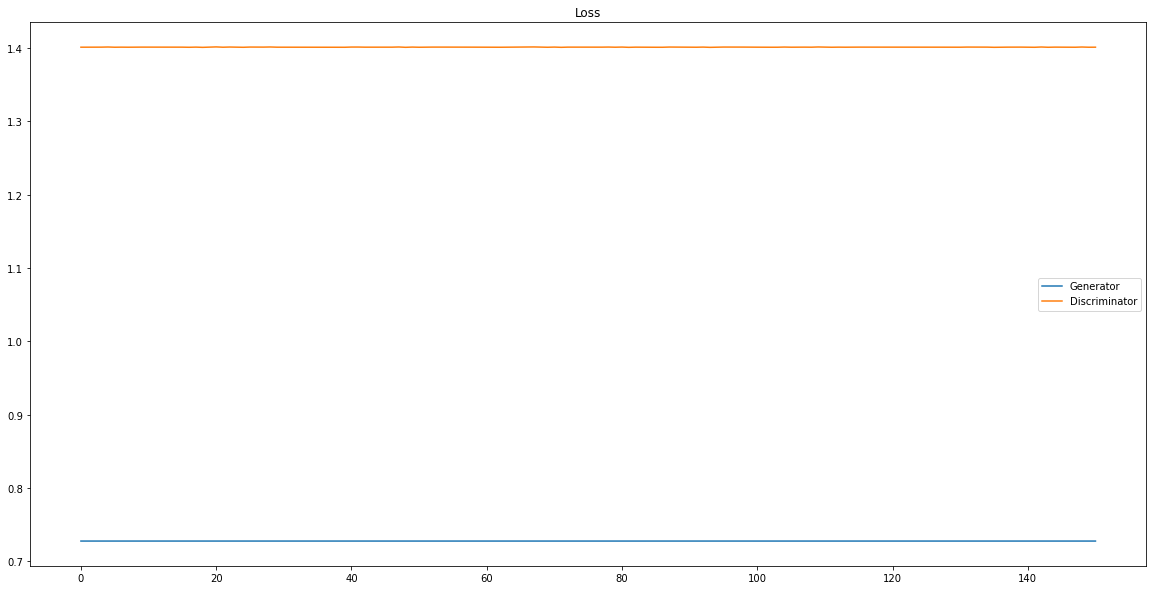

In [98]:
plt.figure(figsize=(20, 10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator', 'Discriminator'])
plt.title("Loss")
plt.savefig('gan_loss.png')

--------------------------------------------------------------------------------------------------

### 2. Deep Convolutional GAN (DCGAN)

- DCGAN : GAN 구조를 합성곱 층으로 구성한 모델
- 합성곱 신경망은 MLP보다 이미지 처리에 매우 유리한 네트워크
- 실제 MLP로 구성된 GAN보다 DCGAN을 통해 더 선명한 이미지를 생성할 수 있다. 

#### 💡 생성자 구축하기

- x : 크기가 128인 잠재 변수를 가지고 채널이 128인 1x1 크기 이미지를 입력값으로 받는다. 
- 28x28 이미지 한 장을 얻기 위해 nn.ConvTranspose2d 
    - 입력 성분(Conv2의 결과)을 출력 성분(Conv2의 입력)으로 미분하여 그 값을 입력 벡터와 곱해 출력 벡터를 산출하고, 그 결과 벡터를 행렬 형태로 변환하는 연산
    - **(입력 채널 수, 출력 채널 수, 필터 크기, stride, padding)**을 입력
    - 크기는 일반적인 정사각형 이미지와 필터를 사용했을 경우, 다음 식에 의해 피쳐맵의 크기를 산출
    - **(출력값의 크기) = (입력값의 크기 - 1)x(보폭) - 2x(패딩) + (필터의 크기) + (출력값 패딩)**
    - 예를 들어 입력값이 1x1 이미지이고, (stride=1, padding=0, filter size = 3x3, padding=0)이면 출력값의 크기는 3이 되고, 계산과정을 반복하면 28x28 이미지 얻을 수 있다. 

In [100]:
class Generator(nn.Module) :
    def __init__(self) :
        super(Generator, self).__init__()
        self.n_features = 128
        self.conv = nn.Sequential(nn.ConvTranspose2d(self.n_features, 256, 3, 1, bias=True),
                                  nn.ReLU(True),
                                  nn.ConvTranspose2d(256, 128, 3, 2, bias=False),
                                  nn.ReLU(True),
                                  nn.ConvTranspose2d(128, 64, 3, 2, bias=False),
                                  nn.ReLU(True),
                                  nn.ConvTranspose2d(64, 1, 2, 2, 1, bias=False),
                                  nn.Tanh())
        
    def forward(self, x) :
        # 입력값이 1x1 이미지 (생소할 수도 있다.)
        x = x.view(-1, self.n_features, 1, 1)
        x = self.conv(x)
        return x

In [116]:
generator = Generator().to(device)

In [117]:
import torchsummary
torchsummary.summary(generator, input_size=(100, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         295,168
              ReLU-2            [-1, 256, 3, 3]               0
   ConvTranspose2d-3            [-1, 128, 7, 7]         294,912
              ReLU-4            [-1, 128, 7, 7]               0
   ConvTranspose2d-5           [-1, 64, 15, 15]          73,728
              ReLU-6           [-1, 64, 15, 15]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]             256
              Tanh-8            [-1, 1, 28, 28]               0
Total params: 664,064
Trainable params: 664,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.36
Params size (MB): 2.53
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


#### 💡 구별자 구축하기

In [118]:
class Discriminator(nn.Module) :
    def __init__(self) :
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 128, 3, 2, 1, bias=False),
                                  nn.LeakyReLU(0.2),
                                  nn.Dropout(0.5),
                                  nn.Conv2d(128, 256, 3, 2, 1, bias=False),
                                  nn.LeakyReLU(0.2),
                                  nn.Dropout(0.5),
                                  nn.Conv2d(256, 256, 3, 2, 1, bias=False),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Dropout(0.5),
                                  nn.Conv2d(256, 1, 3, 2, bias=False),
                                  nn.sigmoid())
        
    def forward(self, x) :
        x = self.conv(x)
        return x.view(-1, 1)